In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
train = pd.read_csv('train.csv')
org = pd.read_csv('healthcare-dataset-stroke-data.csv')

train = pd.concat([train, org])

test = pd.read_csv('test.csv')
ids = test['id']
df = pd.concat([train, test])

In [27]:
df = df.drop(columns = ['id'])
df['bmi'] = df['bmi'].fillna(df.groupby(['age', 'gender'])['bmi'].transform('mean'))

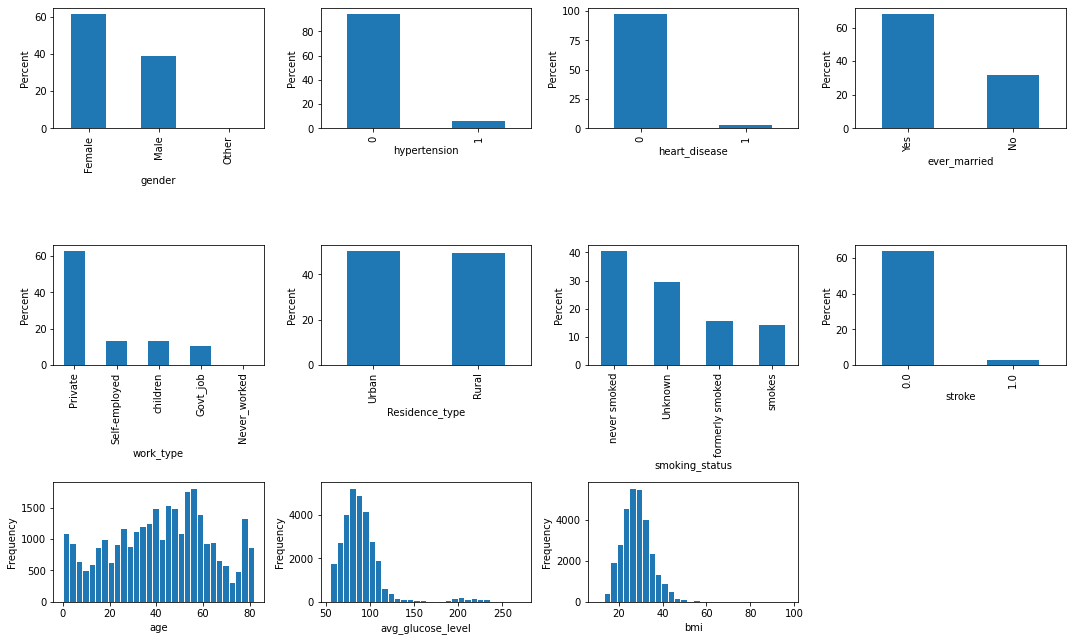

In [32]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type',
               'smoking_status', 'stroke']
numerical = df.drop(columns = categorical).columns

fig, axes = plt.subplots(3, 4, figsize=(15, 9))
axes = axes.flatten()

for i, col in enumerate(categorical):
    (100* df[col].value_counts() / len(df)).plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percent')
    
for i, col in enumerate(numerical):
    j = i+len(categorical)
    
    df[col].plot.hist(ax = axes[j], bins = 30, edgecolor='white')
    axes[j].set_xlabel(col)
    
for ax in axes[j+1:]:
    ax.axis('off')
    
plt.tight_layout()

In [33]:
smoke_stat = ['Unknown', 'never smoked', 'formerly smoked', 'smokes']
smoke_stat = dict(zip(smoke_stat, range(len(smoke_stat))))

df['smoking_status'] = df['smoking_status'].map(smoke_stat)

In [34]:
df_dummy = pd.get_dummies(df)

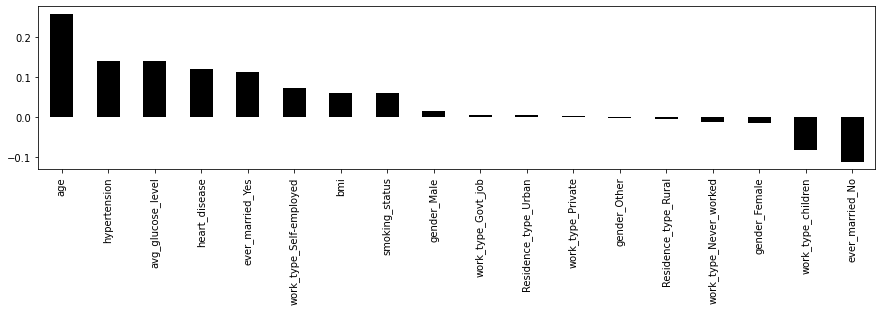

In [35]:
df_dummy.corr()['stroke'].sort_values(ascending=False)[1:].plot.bar(figsize=(15,3), cmap='copper')
plt.show()

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummy.drop(columns='stroke')
y = df_dummy['stroke']

features = X.columns.values

Scaler = MinMaxScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns = features)

X_test = X[len(train):]
X = X.iloc[:len(train)]
y = y.iloc[:len(train)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [39]:
%%time
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict_proba(X_train)[:, 1]
y_valid_pred = model_lr.predict_proba(X_valid)[:, 1]

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.874555563684249
Validation score:  0.8742407729741314
CPU times: user 497 ms, sys: 431 ms, total: 928 ms
Wall time: 266 ms


In [40]:
%%time
model = XGBClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)[:, 1]
y_valid_pred = model.predict_proba(X_valid)[:, 1]

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.9914308100033276
Validation score:  0.8672483051334725
CPU times: user 3.86 s, sys: 30.2 ms, total: 3.89 s
Wall time: 1.12 s


In [46]:
final_model = LogisticRegression(max_iter = 800)
final_model.fit(X, y)
print("Training score: ", metrics.roc_auc_score(y, final_model.predict_proba(X)[:, 1]))
y_test_pred = final_model.predict_proba(X_test)[:, -1]

Training score:  0.8747149168033863


In [47]:
output = pd.DataFrame({'id': ids, 'stroke': y_test_pred})

In [48]:
output.to_csv("Submission4.csv", index=False)